In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

The goal of this code is to generate a polynomial with given combinatorics. Using principles from Teichmüller theory, one can prove the convergence of this algorithm to the desired polynomial.

Throughout the documentation, we use 'rational angle' to refer to an element of $\mathbb{Q}/\mathbb{Z}$ and may omit the implicit multiple of $2\pi$ where appropriate.


The underlying math comes from this paper by John Hubbard and Dierk Schleicher https://pi.math.cornell.edu/~hubbard/SpidersFinal.pdf.
This implementation is by Jeffrey Lantz and Riley Guyett.

In [102]:
FLOAT_ERR = math.pow(10,-7)
# Returns True if the three points are counterclockwise oriented
# Note: TRUE (CHECK THIS) if collinear
def ccw(z1, z2, z3):
    return (z2.imag-z1.imag)*(z3.real-z2.real) < (z2.real-z1.real)*(z3.imag-z2.imag)

# Returns algebraic intersection of seg1 (fixed) and seg2(crossing).
# +1 for left-to-right, -1 for right-to-left, 0 for no intersection.
def intersect_segs(seg1,seg2):
    # Non-collinear segments ab and cd intersect iff ccw(abc) != ccw(abd) and ccw(cda) != ccw(cdb)
    o1= ccw(seg1[0], seg1[1], seg2[0])
    o2= ccw(seg1[0], seg1[1], seg2[1])
    o3= ccw(seg2[0], seg2[1], seg1[0])
    o4= ccw(seg2[0], seg2[1], seg1[1])
    if (o1 != o2) and (o3 != o4):
        # o1 and !o2 and !o3 and o4 is +1.
        # !o1 and o2 and o3 and !o4 is -1.
        # Other cases impossible by geometry
        return 1 if o1 else -1
    else:
        return 0

# Given an array of n points and a segment, returns an array of length n,
# Where the i-th entry is the alg. int. of seg (fixed) with curve[:i+1] (crossing)
def intersect_seg_curve(seg, curve):
    # First line creates boolean array of intersections between segments
    intersects= [intersect_segs(seg,[curve[i],curve[i+1]]) for i in range(len(curve)-1)]
    # Starting from 0, increments at i when intersects[i] is True
    return np.cumsum(np.concatenate(([0],np.asarray(intersects, dtype=np.intc))))

def circumcenter(z1,z2,z3):
    A = np.array([[z3.real-z1.real, z3.imag-z1.imag], [z3.real-z2.real, z3.imag-z2.imag]])
    Y = np.array([np.abs(z3)**2 - np.abs(z1)**2, np.abs(z3)**2 - np.abs(z2)**2])
    return np.dot(np.linalg.inv(A), Y) / 2

# A spider is the fundamental object of our space.
# It has legs that go off to infinity TODO: make sure initial legs are always big enough
# The legs land at points in C and do not cross.
# Spiders may be equivalent under a certain homotopy condition. We require that endpoints[0]==0.
    
# A spider may be defined by just a rational angle
# In this case, it has legs extending radially with endpoints at exp(2^j 2pi i theta)
class Spider:
    def __init__(self, theta= 0, endpoints= np.empty(0), legs= np.empty((0,0)), divline= np.empty(0), knead= np.empty(0), prelength= 0,d=2,r=5):
        self.deg= d
        self.radius = r
        if theta == 0: # Used to construct nonstandard new spider objects
            self.endpoints= endpoints
            self.legs     = legs
            self.divline  = divline
            self.knead    = knead
            self.prelength= prelength
        else: # Construct standard spider from given angle
            # Add doubling angles until the next one would be a repeat (equality if difference < 10^-6)
            angles = np.array([theta])
            while not any(np.abs(angles[-1]*d % 1 - angles[:-1]) < FLOAT_ERR):
                angles = np.append(angles, angles[-1]*d % 1)
            # prelength is index of where last entry doubles to, corresponds to length of preperiodic section
            self.prelength = (np.abs(angles[-1]*d % 1 - angles[:-1]) < FLOAT_ERR).nonzero()[0][0]
            # Legs extend radially from the endpoints, which are at the given angles.
            # Unit circle is divided into A and B by segment connecting the roots of first endpoint
            # Everything is then shifted to put the first endpoint at 0
            self.endpoints = np.exp(2j * np.pi * angles)
            self.legs      = np.kron(np.linspace(1, r, 100), self.endpoints[:, np.newaxis])
            self.divline   = np.linspace(0,1,50)*np.exp(2j*np.pi/d*(theta+np.mgrid[0:d, 0:50][0]))
            # Build kneading sequence, ccw bd points included in region.
            self.knead= np.ceil(d * angles - theta - FLOAT_ERR) - np.ceil((d-1)*theta - FLOAT_ERR)
            # Everything is then shifted to put the first endpoint at 0
            self.endpoints -= np.exp(2j * np.pi * theta)
            self.legs      -= np.exp(2j * np.pi * theta)
            self.divline   -= np.exp(2j * np.pi * theta)
        
    # Shows a graph of the spider
    def graph(self,draw_circle=False,draw_axes=False,draw_divline=True):
        plt.figure(figsize=(10,10))
        for leg in self.legs: # Plot all legs in black
            plt.plot(leg.real, leg.imag, 'black')
        if draw_circle:
            # Used for initial spider, finds z_0 s.t. endpoints lie on |z-z_0|=1, when at least 3 pts
            center = circumcenter(self.endpoints[0],self.endpoints[1],self.endpoints[2])
            plt.plot(np.exp(np.linspace(0, 2*np.pi, 100) * 1j).real + center[0],
                     np.exp(np.linspace(0, 2*np.pi, 100) * 1j).imag + center[1], 'black')
        # Plots the dividing line in red, endpoints in blue, labeled with 1-indexing
        if draw_divline:
            for i in range(len(self.divline)):
                plt.plot(self.divline[i].real, self.divline[i].imag, 'red')
        plt.scatter(self.endpoints.real, self.endpoints.imag, s=20, marker='o')
        for i in range(len(self.endpoints)):
            # Puts labels outwards, ccw from the endpoint
            text_dir= (self.legs[i][1] - self.endpoints[i])
            text_dir*=(8+6j)/np.linalg.norm(text_dir)
            plt.annotate(text= f"$z_{{{i+1}}}$", # uses LaTeX formatting
                         xy  = (self.endpoints[i].real, self.endpoints[i].imag),
                         textcoords="offset points",
                         xytext= (text_dir.real, text_dir.imag),
                         ha='center')
        # Makes sure diagram is square and shows everything
        plt.gca().set_aspect('equal', 'box')
        # Can include real, imaginary axes if desired
        if draw_axes:
            plt.axvline(x=0, c="blue", linestyle="dashed")
            plt.axhline(y=0, c="blue", linestyle="dashed")
        plt.show()
        
    def listpts(self):
        print("knead", self.knead) # Prints the kneading sequence
        print("endpoints:", self.endpoints) # Prints the list of endpoints
        print("new endpoints:",self.update()) # Prints the list of future endpoints
        print("legs:", self.legs) # Prints the legs

def pick_parity(divline, principle_root, knead_term):
    req_parity  = knead_term=='B' or knead_term=='*2'
    inter_parity= intersect_curve_seg(divline,[2*principle_root-2,0])[-1] % 2
    return 1 if req_parity == inter_parity else -1


# Seems to be working in the preperiodic case. Sometimes periodic is taking the wrong root which is bad.
# Might also be having issues when z_1 isn't in the first sector to begin with.
# TODO: Extend legs outwards, maybe radially from -d?
@np.errstate(divide='ignore',invalid='ignore')
def update_spider(spider):
    z_2 = spider.endpoints[1]
    d = spider.deg
    # dividing line is the d lifts of leg to z_1, oriented outwards
    branch = [0, -10*z_2/np.absolute(z_2)]
    div_ints = intersect_seg_curve(branch, spider.legs[0]) # 10 arbitrary
    div_roots = np.mgrid[0:d, 0:len(spider.legs[0])][0] - div_ints
    new_divline= d*np.exp(np.log(spider.legs[0]/z_2)/d + 2j*np.pi/d * (div_roots))-d
    new_endpoints = np.empty_like(spider.endpoints)
    new_legs      = np.empty_like(spider.legs)
    for i in range(len(spider.endpoints)-1):
        ints = intersect_seg_curve([spider.endpoints[0], spider.endpoints[i+1]], spider.legs[0])
        new_endpoints[i] = d*np.exp((np.log(spider.endpoints[i+1] / z_2) +
                                     2j*np.pi*(spider.knead[i]-ints[-1])) / d)-d
        leg_branch_int= intersect_seg_curve(branch, spider.legs[i+1])
        new_legs[i]= d*np.exp((np.log(spider.legs[i+1] / z_2) + 
                               2j*np.pi*(spider.knead[i]-ints[-1]-leg_branch_int)) / d)-d
    ints = intersect_seg_curve([spider.endpoints[0], spider.endpoints[spider.prelength]], spider.legs[0])
    #adjustment in the periodic case when principal root is cw from 0
    periodic_adjust= int(spider.prelength == 0 and ccw(z_2,spider.endpoints[0], spider.legs[0][1]))
    new_endpoints[-1] = d*np.exp((np.log(spider.endpoints[spider.prelength] / z_2) +
                                     2j*np.pi*(spider.knead[-1]-ints[-1] + periodic_adjust)) / d)-d
    leg_branch_int= intersect_seg_curve(branch, spider.legs[spider.prelength])
    new_legs[-1]= d*np.exp((np.log(spider.legs[spider.prelength] / z_2) + 
                               2j*np.pi*(spider.knead[-1]-ints[-1]-leg_branch_int + periodic_adjust)) / d)-d
    addon_legs = np.empty_like(spider.legs)
    for i in range(len(spider.endpoints)):
        end = new_legs[i][-1]
        addon_legs[i] = np.linspace(end, spider.radius*((end+d)/np.absolute(end+d))-d, num=len(spider.legs[i]))
        #addon_legs = np.empty_like(spider.legs[i])
        #for j in range(len(addon_legs)):
        #    addon_legs[j] = (1+j*0.01)*(end.real+spider.deg)-spider.deg + 1j*((1+j*0.01)*end.imag)
        #stack = np.hstack((new_legs[i],addon_legs))
        #for j in range(len(new_legs[i])):
        #    new_legs[i][j] = stack[2*j]
    print(new_legs.shape, addon_legs.shape)
    new_legs = np.concatenate((new_legs, addon_legs), axis=1)[:,::2]
    return Spider(endpoints=new_endpoints,legs=new_legs, divline=new_divline, knead = spider.knead, prelength=spider.prelength, d=d)

In [117]:
favorite = Spider(theta=4/11, d=3)
print(favorite.knead)

[ 0. -1.  0.  2.  0.]


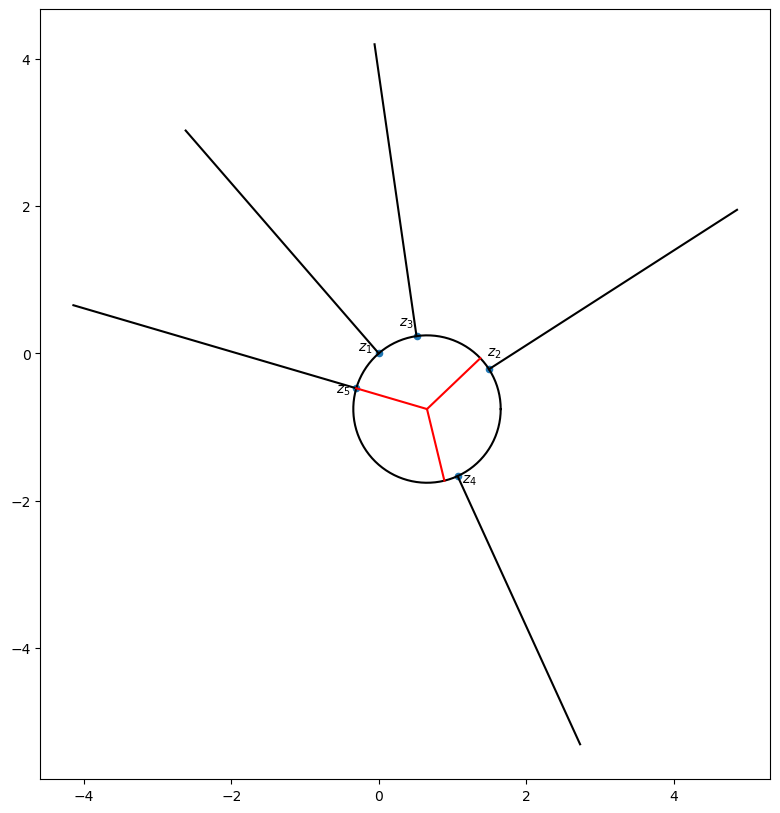

In [118]:
favorite.graph(draw_circle=True)

In [119]:
#z_2_orig = favorite.endpoints[1]
new = update_spider(favorite)

(5, 100) (5, 100)


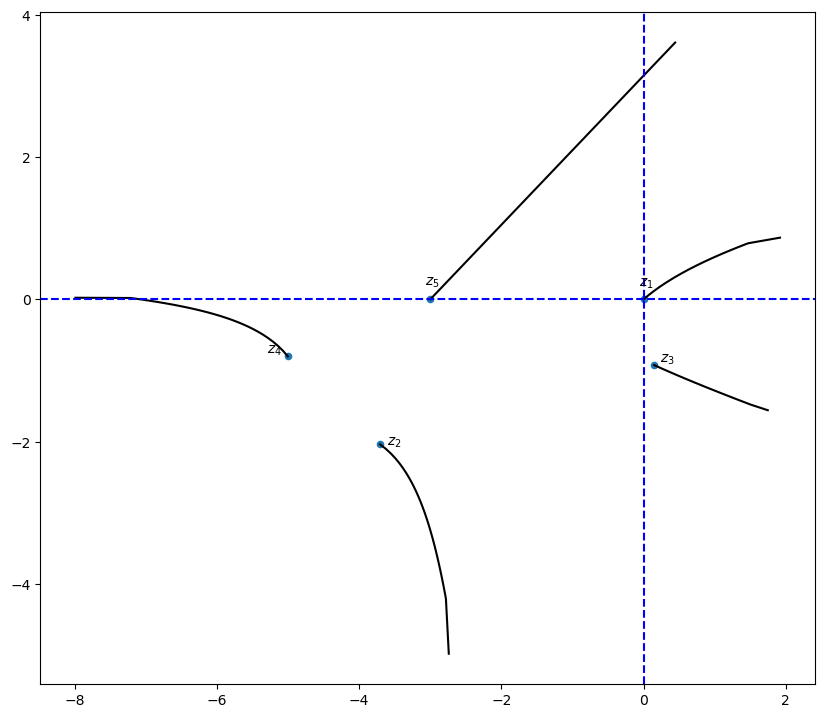

In [120]:
new.graph(draw_axes=True,draw_divline=False)

In [ ]:
#test_spider = Spider(endpoints=np.append(0,z_2_orig*(1+new.endpoints[:-1]/2)**2), legs=z_2_orig*(1+np.append(np.reshape(new.divline[99:],(1,100)),new.legs,axis=0)/2)**2)
#shift_spider(test_spider,-1*shift)
#test_spider.graph(True)

In [ ]:
#print(test_spider.endpoints)
#print(favorite.endpoints+shift)
print(favorite.prelength, favorite.knead)

In [ ]:
#Demonstrate curve orienatation
seg_ex = [0+0j, 5+0j]
curve_ex = [0-1j, 1+1j, 2-1j, 3+1j, 4-1j, 5+1j]
print(intersect_seg_curve(seg_ex, curve_ex))
print(ccw(0+0j,5+0j,0-1j))

In [ ]:
new = update_spider(new)
new.graph(draw_axes=True,draw_divline=True)

In [85]:
print(new.legs.shape)

(6, 100)


(5, 100) (5, 100)


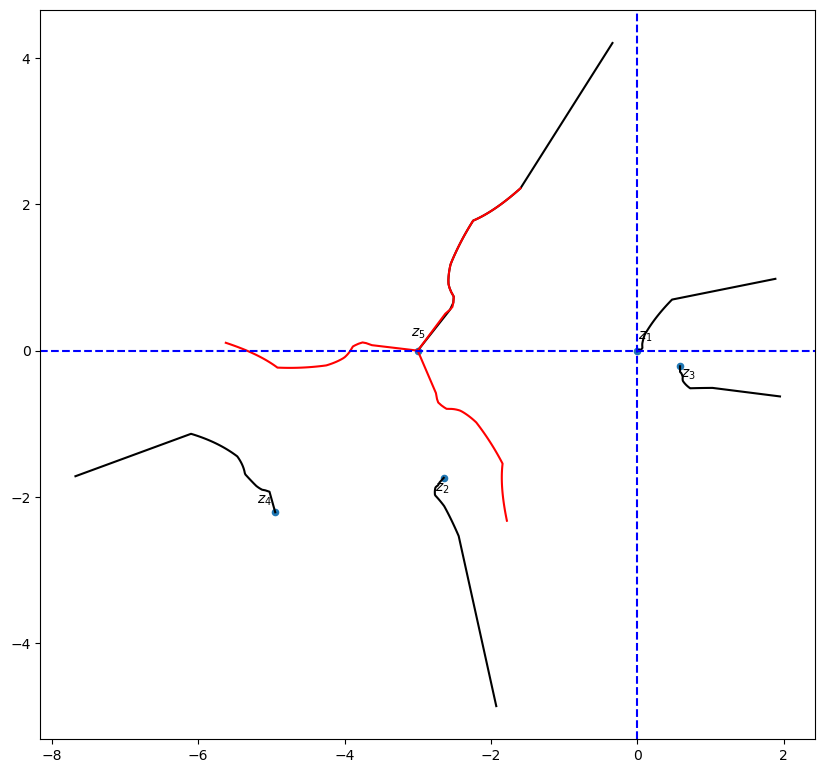

In [128]:
new = update_spider(new)
new.graph(draw_axes=True,draw_divline=True)

In [88]:
np.array([[0,1,2,3,4,5,6],[0,-1,-2,-3,-4,-5,-6]])[:,::2]

array([[ 0,  2,  4,  6],
       [ 0, -2, -4, -6]])